# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

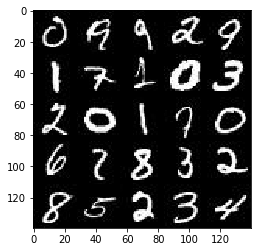

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

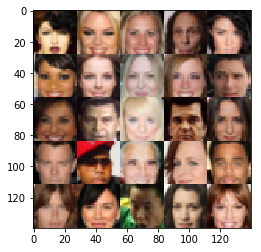

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    fake_inputs = tf.placeholder(tf.float32, shape=[None, z_dim])
    lr = tf.placeholder(tf.float32)
    return real_inputs, fake_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) # leaky relu
        # 14x14x64 (because of strides / 2)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*256)
        nn = tf.layers.batch_normalization(x, training=is_train)
        
        # Reshape before passing to conv layer
        nn = tf.reshape(nn, (-1, 7, 7, 256))
        # Leaky relu
        nn = tf.maximum(alpha * nn, nn)
        # shape=(?, 7, 7, 256)
        
        nn = tf.layers.conv2d_transpose(nn, 128, (5, 5), strides=1, padding='same')
        nn = tf.layers.batch_normalization(nn, training=is_train)
        nn = tf.maximum(alpha * nn, nn)
        # shape=(?, 7, 7, 128) # because of stride 1
        
        nn = tf.layers.conv2d_transpose(nn, 64, (5, 5), strides=2, padding='same')
        nn = tf.layers.batch_normalization(nn, training=is_train)
        nn = tf.maximum(alpha * nn, nn)
        # shape=(?, 14, 14, 64)
    
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(nn, out_channel_dim, (5, 5), strides=2, padding='same')
        out = tf.tanh(logits)
            
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          show_every=100, print_every=15):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Create the model inputs
    real_inputs, fake_inputs, lr_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Get the loss for the discriminator and generator
    d_loss, g_loss = model_loss(real_inputs, fake_inputs, data_shape[3])
    
    # Get optimization operations
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)
    
    losses = []
    n_img_show = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for step, batch_images in enumerate(get_batches(batch_size)):
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                sess.run(d_train_opt, feed_dict={real_inputs: batch_images, 
                                                 fake_inputs: batch_z, 
                                                 lr_tensor: learning_rate})
                
                sess.run(g_train_opt, feed_dict={real_inputs: batch_images, 
                                                 fake_inputs: batch_z, 
                                                 lr_tensor: learning_rate})
                
                if step % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_inputs: batch_images, fake_inputs: batch_z})
                    train_loss_g = g_loss.eval({fake_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
        show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
        print("Last train discriminator Loss: {:.4f}\nLast train generator Loss: {:.4f}".format(losses[-1][0], losses[-1][1]))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.4964... Generator Loss: 0.0100


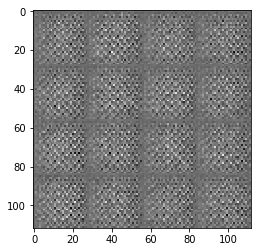

Epoch 1/2... Discriminator Loss: 0.0975... Generator Loss: 11.1723
Epoch 1/2... Discriminator Loss: 0.6613... Generator Loss: 1.8453
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 0.6605
Epoch 1/2... Discriminator Loss: 0.4273... Generator Loss: 5.6958
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.5526
Epoch 1/2... Discriminator Loss: 0.2224... Generator Loss: 4.7553


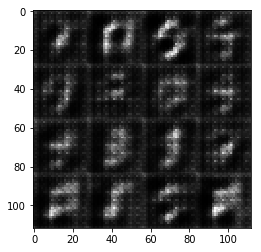

Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.9147... Generator Loss: 6.3259
Epoch 1/2... Discriminator Loss: 1.8885... Generator Loss: 0.2311
Epoch 1/2... Discriminator Loss: 0.0881... Generator Loss: 3.2973
Epoch 1/2... Discriminator Loss: 0.2415... Generator Loss: 1.8857
Epoch 1/2... Discriminator Loss: 0.5393... Generator Loss: 2.0153
Epoch 1/2... Discriminator Loss: 0.7851... Generator Loss: 2.0205


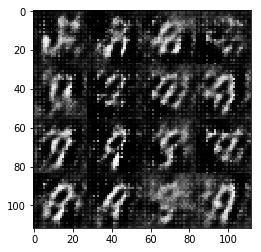

Epoch 1/2... Discriminator Loss: 0.4880... Generator Loss: 1.2835
Epoch 1/2... Discriminator Loss: 0.1744... Generator Loss: 2.4809
Epoch 1/2... Discriminator Loss: 0.3538... Generator Loss: 1.4064
Epoch 1/2... Discriminator Loss: 3.1221... Generator Loss: 0.0639
Epoch 1/2... Discriminator Loss: 0.2555... Generator Loss: 2.5801
Epoch 1/2... Discriminator Loss: 3.9462... Generator Loss: 0.0513
Epoch 1/2... Discriminator Loss: 0.3104... Generator Loss: 1.5789


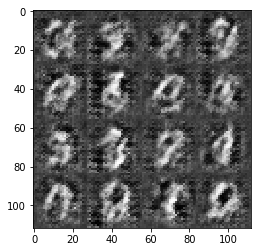

Epoch 1/2... Discriminator Loss: 0.4685... Generator Loss: 1.1802
Epoch 1/2... Discriminator Loss: 1.6384... Generator Loss: 1.4160
Epoch 1/2... Discriminator Loss: 2.2668... Generator Loss: 0.1365
Epoch 1/2... Discriminator Loss: 0.4395... Generator Loss: 2.8298
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 0.3192
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 0.4269


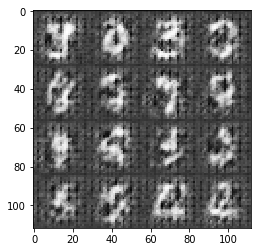

Epoch 1/2... Discriminator Loss: 0.5367... Generator Loss: 1.1604
Epoch 1/2... Discriminator Loss: 0.2182... Generator Loss: 2.0861
Epoch 1/2... Discriminator Loss: 0.9574... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 0.5619... Generator Loss: 1.0623
Epoch 1/2... Discriminator Loss: 0.5973... Generator Loss: 0.9796
Epoch 1/2... Discriminator Loss: 0.1019... Generator Loss: 2.8732
Epoch 1/2... Discriminator Loss: 0.1012... Generator Loss: 2.7884


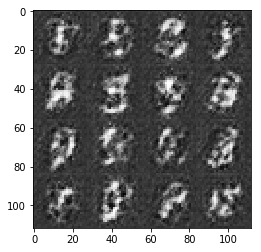

Epoch 1/2... Discriminator Loss: 0.1800... Generator Loss: 2.0053
Epoch 1/2... Discriminator Loss: 0.0746... Generator Loss: 3.4431
Epoch 1/2... Discriminator Loss: 3.1603... Generator Loss: 4.4355
Epoch 1/2... Discriminator Loss: 0.6789... Generator Loss: 1.1583
Epoch 1/2... Discriminator Loss: 0.1708... Generator Loss: 2.3597
Epoch 1/2... Discriminator Loss: 0.0830... Generator Loss: 3.0535
Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 1.0835


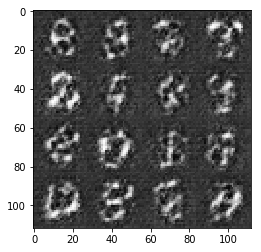

Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 0.5208
Epoch 1/2... Discriminator Loss: 2.3570... Generator Loss: 4.4924
Epoch 1/2... Discriminator Loss: 1.0374... Generator Loss: 0.5529
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 1.1932
Epoch 1/2... Discriminator Loss: 0.2385... Generator Loss: 2.3233
Epoch 1/2... Discriminator Loss: 0.5078... Generator Loss: 1.2797


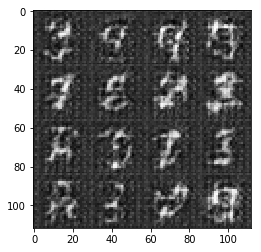

Epoch 1/2... Discriminator Loss: 0.4094... Generator Loss: 1.3606
Epoch 1/2... Discriminator Loss: 0.2126... Generator Loss: 2.1935
Epoch 1/2... Discriminator Loss: 0.2938... Generator Loss: 1.6552
Epoch 1/2... Discriminator Loss: 0.2353... Generator Loss: 1.9706
Epoch 1/2... Discriminator Loss: 0.2734... Generator Loss: 1.6365
Epoch 1/2... Discriminator Loss: 0.1102... Generator Loss: 2.7080
Epoch 1/2... Discriminator Loss: 0.0695... Generator Loss: 3.3851


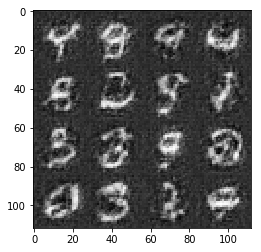

Epoch 1/2... Discriminator Loss: 0.0510... Generator Loss: 3.6162
Epoch 1/2... Discriminator Loss: 0.0694... Generator Loss: 3.4433
Epoch 1/2... Discriminator Loss: 0.0854... Generator Loss: 4.4553
Epoch 1/2... Discriminator Loss: 0.0481... Generator Loss: 4.5942
Epoch 1/2... Discriminator Loss: 0.0335... Generator Loss: 3.9887
Epoch 1/2... Discriminator Loss: 2.4180... Generator Loss: 0.2176
Epoch 1/2... Discriminator Loss: 0.5752... Generator Loss: 1.5724


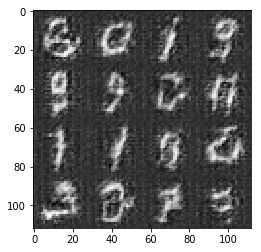

Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.0640... Generator Loss: 0.7411
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 4.3774
Epoch 1/2... Discriminator Loss: 0.3595... Generator Loss: 1.8271
Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.3256
Epoch 1/2... Discriminator Loss: 0.2923... Generator Loss: 1.7119


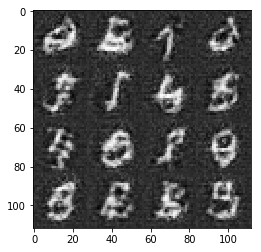

Epoch 1/2... Discriminator Loss: 0.4930... Generator Loss: 1.2132
Epoch 1/2... Discriminator Loss: 0.0391... Generator Loss: 4.1050
Epoch 1/2... Discriminator Loss: 0.0366... Generator Loss: 4.3526
Epoch 1/2... Discriminator Loss: 0.0557... Generator Loss: 3.4088
Epoch 1/2... Discriminator Loss: 0.0463... Generator Loss: 3.9327
Epoch 1/2... Discriminator Loss: 0.0194... Generator Loss: 5.3674
Epoch 1/2... Discriminator Loss: 0.0958... Generator Loss: 2.9915


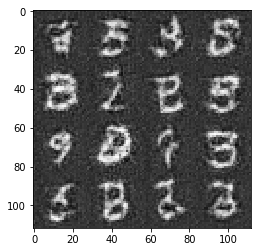

Epoch 1/2... Discriminator Loss: 0.1019... Generator Loss: 2.5661
Epoch 1/2... Discriminator Loss: 5.6409... Generator Loss: 0.0300
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 0.7272... Generator Loss: 2.0826
Epoch 1/2... Discriminator Loss: 0.5407... Generator Loss: 1.8453
Epoch 1/2... Discriminator Loss: 0.4718... Generator Loss: 2.5190
Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 1.1963


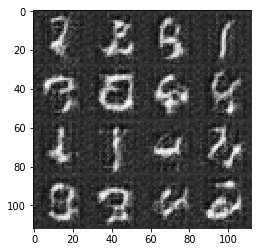

Epoch 1/2... Discriminator Loss: 0.6005... Generator Loss: 2.3181
Epoch 1/2... Discriminator Loss: 0.3910... Generator Loss: 1.5802
Epoch 1/2... Discriminator Loss: 0.6362... Generator Loss: 0.9057
Epoch 1/2... Discriminator Loss: 0.4037... Generator Loss: 1.4111
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 1.0838
Epoch 1/2... Discriminator Loss: 0.1994... Generator Loss: 2.5696


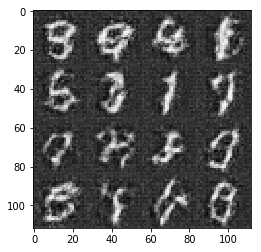

Epoch 1/2... Discriminator Loss: 0.6224... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 2.0073... Generator Loss: 0.3929
Epoch 1/2... Discriminator Loss: 0.1994... Generator Loss: 2.0139
Epoch 1/2... Discriminator Loss: 0.3055... Generator Loss: 1.5896
Epoch 1/2... Discriminator Loss: 0.1633... Generator Loss: 2.3729
Epoch 1/2... Discriminator Loss: 0.4796... Generator Loss: 1.2472
Epoch 1/2... Discriminator Loss: 0.1375... Generator Loss: 2.5235


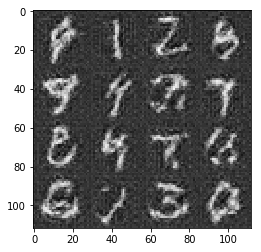

Epoch 1/2... Discriminator Loss: 0.0993... Generator Loss: 2.9261
Epoch 1/2... Discriminator Loss: 0.0840... Generator Loss: 2.7960
Epoch 1/2... Discriminator Loss: 0.3500... Generator Loss: 1.4428
Epoch 1/2... Discriminator Loss: 0.1463... Generator Loss: 2.3570
Epoch 1/2... Discriminator Loss: 0.0238... Generator Loss: 4.2457
Epoch 1/2... Discriminator Loss: 0.0173... Generator Loss: 4.5728
Epoch 1/2... Discriminator Loss: 0.0338... Generator Loss: 3.9443


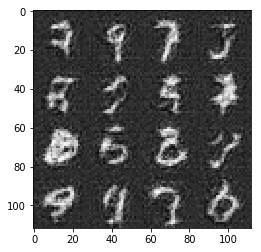

Epoch 1/2... Discriminator Loss: 0.0434... Generator Loss: 3.6408
Epoch 1/2... Discriminator Loss: 0.0210... Generator Loss: 4.4531
Epoch 1/2... Discriminator Loss: 0.1109... Generator Loss: 2.5358
Epoch 1/2... Discriminator Loss: 0.0699... Generator Loss: 3.0712
Epoch 1/2... Discriminator Loss: 0.0869... Generator Loss: 2.8144
Epoch 1/2... Discriminator Loss: 0.0107... Generator Loss: 5.4801


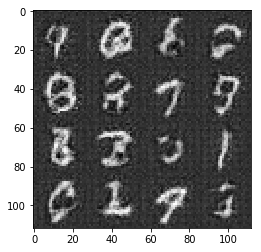

Epoch 1/2... Discriminator Loss: 0.0470... Generator Loss: 3.4824
Epoch 1/2... Discriminator Loss: 0.2175... Generator Loss: 1.9178
Epoch 1/2... Discriminator Loss: 0.1264... Generator Loss: 2.6971
Epoch 1/2... Discriminator Loss: 0.0226... Generator Loss: 4.4288
Epoch 1/2... Discriminator Loss: 0.0863... Generator Loss: 2.9310
Epoch 1/2... Discriminator Loss: 0.1287... Generator Loss: 2.5196
Epoch 1/2... Discriminator Loss: 0.0121... Generator Loss: 5.0882


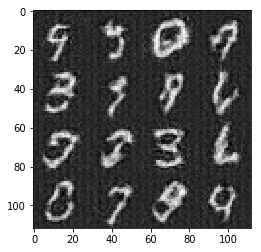

Epoch 1/2... Discriminator Loss: 0.0854... Generator Loss: 2.8123
Epoch 1/2... Discriminator Loss: 0.1585... Generator Loss: 2.3429
Epoch 1/2... Discriminator Loss: 0.0415... Generator Loss: 3.8332
Epoch 1/2... Discriminator Loss: 0.0407... Generator Loss: 3.8626
Epoch 1/2... Discriminator Loss: 0.0130... Generator Loss: 5.1892
Epoch 1/2... Discriminator Loss: 0.0365... Generator Loss: 3.9276
Epoch 1/2... Discriminator Loss: 0.0900... Generator Loss: 2.8499


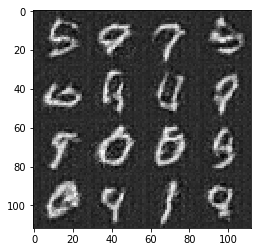

Epoch 1/2... Discriminator Loss: 0.0069... Generator Loss: 5.5780
Epoch 1/2... Discriminator Loss: 0.0649... Generator Loss: 3.1972
Epoch 1/2... Discriminator Loss: 0.0163... Generator Loss: 4.7056
Epoch 1/2... Discriminator Loss: 1.8057... Generator Loss: 0.3089
Epoch 2/2... Discriminator Loss: 1.3377... Generator Loss: 0.9344


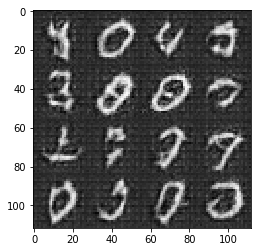

Epoch 2/2... Discriminator Loss: 1.2031... Generator Loss: 1.3461
Epoch 2/2... Discriminator Loss: 1.0394... Generator Loss: 1.8660
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 0.6189
Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 1.3214
Epoch 2/2... Discriminator Loss: 1.6610... Generator Loss: 0.4220


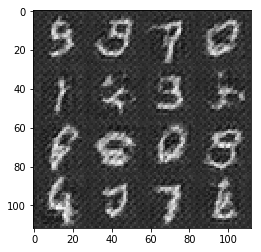

Epoch 2/2... Discriminator Loss: 0.5525... Generator Loss: 1.2798
Epoch 2/2... Discriminator Loss: 0.6642... Generator Loss: 1.0778
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 3.3480
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 2.0691
Epoch 2/2... Discriminator Loss: 0.6159... Generator Loss: 1.2671
Epoch 2/2... Discriminator Loss: 0.3708... Generator Loss: 1.6525
Epoch 2/2... Discriminator Loss: 0.3817... Generator Loss: 2.2669


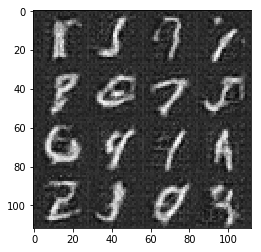

Epoch 2/2... Discriminator Loss: 0.4121... Generator Loss: 2.5394
Epoch 2/2... Discriminator Loss: 0.5782... Generator Loss: 3.1641
Epoch 2/2... Discriminator Loss: 0.2023... Generator Loss: 2.7430
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 1.7274
Epoch 2/2... Discriminator Loss: 0.5749... Generator Loss: 3.1528
Epoch 2/2... Discriminator Loss: 0.4848... Generator Loss: 1.4736
Epoch 2/2... Discriminator Loss: 0.6753... Generator Loss: 1.0222


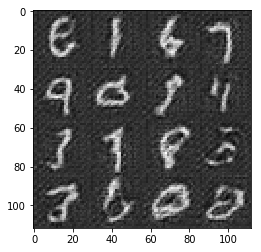

Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 1.8308
Epoch 2/2... Discriminator Loss: 0.4028... Generator Loss: 2.2465
Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 0.5582
Epoch 2/2... Discriminator Loss: 0.4023... Generator Loss: 1.5586
Epoch 2/2... Discriminator Loss: 0.4995... Generator Loss: 1.3492
Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 0.6832


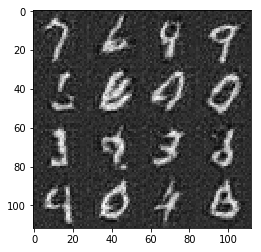

Epoch 2/2... Discriminator Loss: 0.2054... Generator Loss: 2.0437
Epoch 2/2... Discriminator Loss: 0.0494... Generator Loss: 3.6821
Epoch 2/2... Discriminator Loss: 0.0517... Generator Loss: 3.8431
Epoch 2/2... Discriminator Loss: 0.0709... Generator Loss: 3.3741
Epoch 2/2... Discriminator Loss: 0.3716... Generator Loss: 2.2655
Epoch 2/2... Discriminator Loss: 0.3901... Generator Loss: 1.7869
Epoch 2/2... Discriminator Loss: 0.5640... Generator Loss: 1.8985


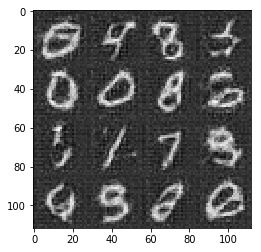

Epoch 2/2... Discriminator Loss: 0.6870... Generator Loss: 0.9367
Epoch 2/2... Discriminator Loss: 0.4166... Generator Loss: 1.6083
Epoch 2/2... Discriminator Loss: 0.4575... Generator Loss: 1.4879
Epoch 2/2... Discriminator Loss: 1.3504... Generator Loss: 0.4651
Epoch 2/2... Discriminator Loss: 0.3397... Generator Loss: 2.0005
Epoch 2/2... Discriminator Loss: 0.5109... Generator Loss: 1.3361
Epoch 2/2... Discriminator Loss: 0.1802... Generator Loss: 2.2151


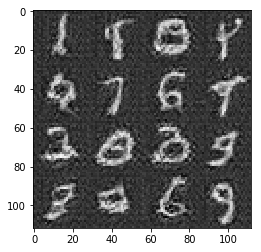

Epoch 2/2... Discriminator Loss: 0.2295... Generator Loss: 2.1208
Epoch 2/2... Discriminator Loss: 0.2177... Generator Loss: 2.0844
Epoch 2/2... Discriminator Loss: 0.2091... Generator Loss: 2.1393
Epoch 2/2... Discriminator Loss: 0.1154... Generator Loss: 2.8753
Epoch 2/2... Discriminator Loss: 0.0169... Generator Loss: 4.9571
Epoch 2/2... Discriminator Loss: 0.0299... Generator Loss: 4.2341


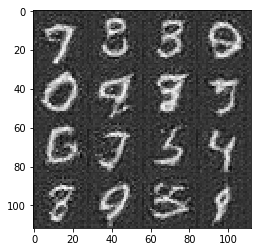

Epoch 2/2... Discriminator Loss: 0.1475... Generator Loss: 2.8964
Epoch 2/2... Discriminator Loss: 0.0607... Generator Loss: 3.6034
Epoch 2/2... Discriminator Loss: 0.0206... Generator Loss: 4.9335
Epoch 2/2... Discriminator Loss: 0.0504... Generator Loss: 3.5132
Epoch 2/2... Discriminator Loss: 0.2065... Generator Loss: 2.1921
Epoch 2/2... Discriminator Loss: 0.0392... Generator Loss: 3.8659
Epoch 2/2... Discriminator Loss: 0.0141... Generator Loss: 5.4003


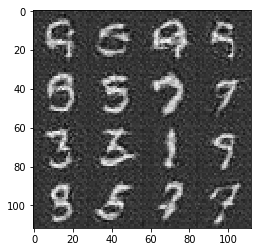

Epoch 2/2... Discriminator Loss: 0.0196... Generator Loss: 4.3610
Epoch 2/2... Discriminator Loss: 0.3196... Generator Loss: 1.7736
Epoch 2/2... Discriminator Loss: 0.0206... Generator Loss: 4.7724
Epoch 2/2... Discriminator Loss: 0.0303... Generator Loss: 4.2459
Epoch 2/2... Discriminator Loss: 0.0153... Generator Loss: 4.7477
Epoch 2/2... Discriminator Loss: 0.3552... Generator Loss: 1.6269
Epoch 2/2... Discriminator Loss: 0.2822... Generator Loss: 1.9498


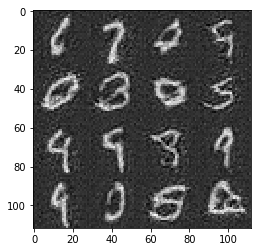

Epoch 2/2... Discriminator Loss: 0.0347... Generator Loss: 4.0765
Epoch 2/2... Discriminator Loss: 0.0545... Generator Loss: 3.4432
Epoch 2/2... Discriminator Loss: 0.1795... Generator Loss: 2.3411
Epoch 2/2... Discriminator Loss: 0.0133... Generator Loss: 6.0528
Epoch 2/2... Discriminator Loss: 2.4871... Generator Loss: 9.1460
Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 0.9833


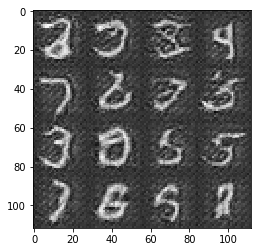

Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 1.3203
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 3.0875
Epoch 2/2... Discriminator Loss: 0.3954... Generator Loss: 1.8924
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 2.2483
Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 0.3956... Generator Loss: 1.7703
Epoch 2/2... Discriminator Loss: 0.3311... Generator Loss: 2.4611


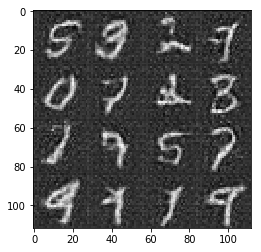

Epoch 2/2... Discriminator Loss: 0.4446... Generator Loss: 3.0579
Epoch 2/2... Discriminator Loss: 0.3700... Generator Loss: 1.6075
Epoch 2/2... Discriminator Loss: 0.6422... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 0.6142... Generator Loss: 1.0767
Epoch 2/2... Discriminator Loss: 0.3299... Generator Loss: 2.0279
Epoch 2/2... Discriminator Loss: 0.6269... Generator Loss: 0.9194


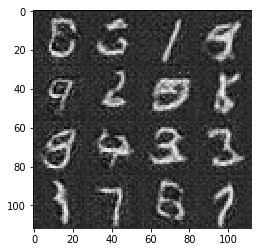

Epoch 2/2... Discriminator Loss: 0.3737... Generator Loss: 1.8462
Epoch 2/2... Discriminator Loss: 0.3695... Generator Loss: 1.6704
Epoch 2/2... Discriminator Loss: 0.2710... Generator Loss: 2.2810
Epoch 2/2... Discriminator Loss: 0.3413... Generator Loss: 3.5854
Epoch 2/2... Discriminator Loss: 0.6206... Generator Loss: 1.0996
Epoch 2/2... Discriminator Loss: 0.1944... Generator Loss: 2.5409


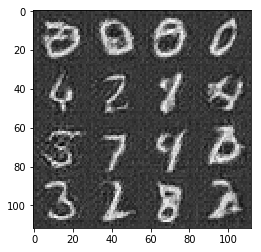

Epoch 2/2... Discriminator Loss: 0.1571... Generator Loss: 2.3308
Epoch 2/2... Discriminator Loss: 0.3060... Generator Loss: 1.8221
Epoch 2/2... Discriminator Loss: 0.4212... Generator Loss: 1.5160
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 2.1718
Epoch 2/2... Discriminator Loss: 0.2867... Generator Loss: 2.2168
Epoch 2/2... Discriminator Loss: 0.3127... Generator Loss: 2.7071
Epoch 2/2... Discriminator Loss: 0.6738... Generator Loss: 0.9102


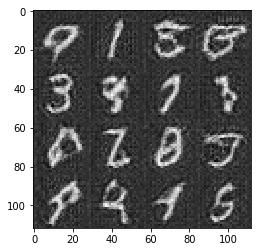

Epoch 2/2... Discriminator Loss: 0.3359... Generator Loss: 2.4510
Epoch 2/2... Discriminator Loss: 0.3120... Generator Loss: 2.0374
Epoch 2/2... Discriminator Loss: 0.3883... Generator Loss: 4.0878
Epoch 2/2... Discriminator Loss: 0.1458... Generator Loss: 2.5678
Epoch 2/2... Discriminator Loss: 0.1733... Generator Loss: 2.3428
Epoch 2/2... Discriminator Loss: 0.0988... Generator Loss: 2.8463
Epoch 2/2... Discriminator Loss: 0.1075... Generator Loss: 2.7494


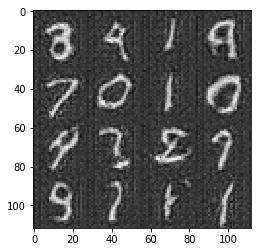

Epoch 2/2... Discriminator Loss: 0.1681... Generator Loss: 2.3035
Epoch 2/2... Discriminator Loss: 0.1319... Generator Loss: 2.7113
Epoch 2/2... Discriminator Loss: 0.0864... Generator Loss: 2.9857
Epoch 2/2... Discriminator Loss: 0.0937... Generator Loss: 3.2746
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 7.0978
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 1.7562


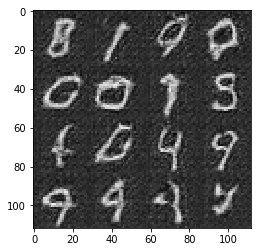

Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 1.2190
Epoch 2/2... Discriminator Loss: 0.5701... Generator Loss: 1.2663
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.5245
Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 3.0490
Epoch 2/2... Discriminator Loss: 0.4169... Generator Loss: 1.5139
Epoch 2/2... Discriminator Loss: 1.7038... Generator Loss: 0.3783
Epoch 2/2... Discriminator Loss: 0.2010... Generator Loss: 2.1638


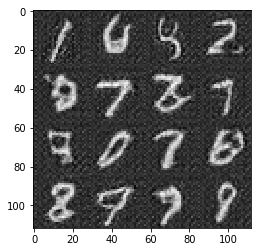

Epoch 2/2... Discriminator Loss: 0.2649... Generator Loss: 1.9492
Epoch 2/2... Discriminator Loss: 0.1336... Generator Loss: 2.7266
Epoch 2/2... Discriminator Loss: 0.1349... Generator Loss: 2.6778
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 1.3004
Epoch 2/2... Discriminator Loss: 0.3210... Generator Loss: 1.8316
Epoch 2/2... Discriminator Loss: 0.5088... Generator Loss: 1.3551
Epoch 2/2... Discriminator Loss: 0.5491... Generator Loss: 1.3662


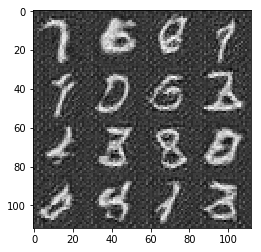

Epoch 2/2... Discriminator Loss: 0.4231... Generator Loss: 1.5849
Epoch 2/2... Discriminator Loss: 0.2430... Generator Loss: 2.1132
Epoch 2/2... Discriminator Loss: 0.0517... Generator Loss: 3.5815
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.5783


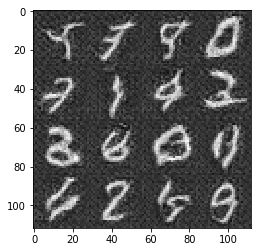

Last train discriminator Loss: 1.2012
Last train generator Loss: 0.5783


In [15]:
batch_size = 32
z_dim = 100
learning_rate = .001
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 13.0044... Generator Loss: 0.0000


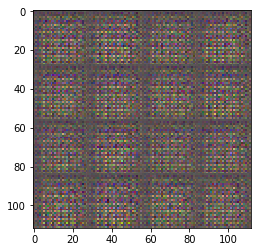

Epoch 1/1... Discriminator Loss: 0.0279... Generator Loss: 9.3817
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 6.3546
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 4.0226
Epoch 1/1... Discriminator Loss: 3.1375... Generator Loss: 0.2146
Epoch 1/1... Discriminator Loss: 0.0600... Generator Loss: 3.3069
Epoch 1/1... Discriminator Loss: 0.0285... Generator Loss: 5.4570


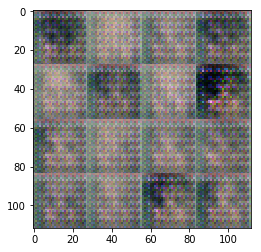

Epoch 1/1... Discriminator Loss: 6.1324... Generator Loss: 8.4977
Epoch 1/1... Discriminator Loss: 0.1564... Generator Loss: 3.3876
Epoch 1/1... Discriminator Loss: 0.0459... Generator Loss: 3.7480
Epoch 1/1... Discriminator Loss: 0.0940... Generator Loss: 3.0493
Epoch 1/1... Discriminator Loss: 0.2467... Generator Loss: 2.7970
Epoch 1/1... Discriminator Loss: 5.7082... Generator Loss: 7.1190
Epoch 1/1... Discriminator Loss: 0.1156... Generator Loss: 2.4927


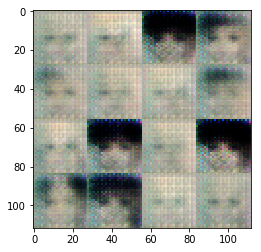

Epoch 1/1... Discriminator Loss: 0.1608... Generator Loss: 2.7548
Epoch 1/1... Discriminator Loss: 0.1759... Generator Loss: 3.3934
Epoch 1/1... Discriminator Loss: 1.7057... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 0.0518... Generator Loss: 4.0439
Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 3.2608
Epoch 1/1... Discriminator Loss: 0.0318... Generator Loss: 5.5704


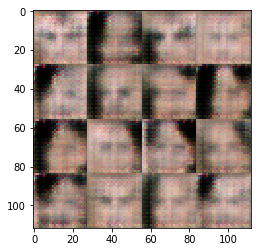

Epoch 1/1... Discriminator Loss: 0.2291... Generator Loss: 2.0478
Epoch 1/1... Discriminator Loss: 0.3321... Generator Loss: 5.0830
Epoch 1/1... Discriminator Loss: 0.1779... Generator Loss: 2.4598
Epoch 1/1... Discriminator Loss: 0.0201... Generator Loss: 9.6025
Epoch 1/1... Discriminator Loss: 0.0610... Generator Loss: 3.6118
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 2.2738


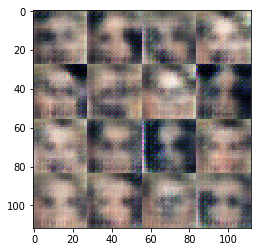

Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 0.2179... Generator Loss: 2.3304
Epoch 1/1... Discriminator Loss: 0.0755... Generator Loss: 3.5709
Epoch 1/1... Discriminator Loss: 7.4896... Generator Loss: 10.4381
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 2.8334
Epoch 1/1... Discriminator Loss: 0.2049... Generator Loss: 2.3066
Epoch 1/1... Discriminator Loss: 0.0482... Generator Loss: 6.7337


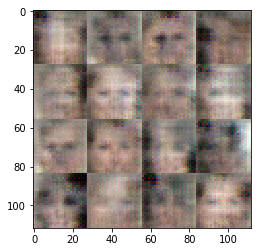

Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.9521... Generator Loss: 2.2545
Epoch 1/1... Discriminator Loss: 2.8663... Generator Loss: 0.1626
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 3.6132


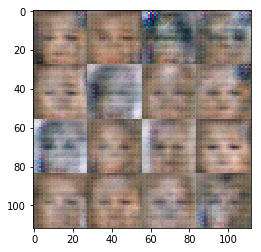

Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 0.2033... Generator Loss: 2.6860
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 0.2271... Generator Loss: 3.3286
Epoch 1/1... Discriminator Loss: 0.0685... Generator Loss: 4.0815
Epoch 1/1... Discriminator Loss: 4.8936... Generator Loss: 4.2656


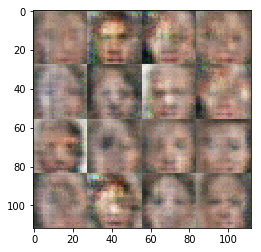

Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 1.4701


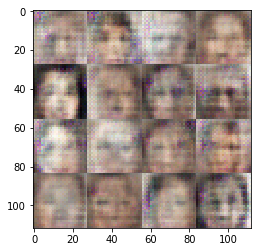

Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 0.1746... Generator Loss: 2.2951
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 0.2591... Generator Loss: 4.5850
Epoch 1/1... Discriminator Loss: 1.7342... Generator Loss: 1.5165
Epoch 1/1... Discriminator Loss: 0.4562... Generator Loss: 2.1890
Epoch 1/1... Discriminator Loss: 2.0460... Generator Loss: 3.5951


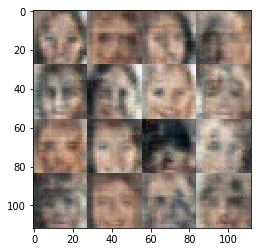

Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 0.1656... Generator Loss: 3.4286
Epoch 1/1... Discriminator Loss: 0.3036... Generator Loss: 2.1937
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.5052
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 6.5537
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 0.9229


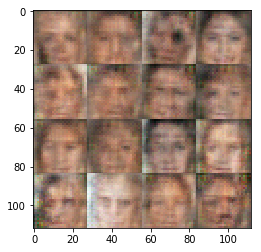

Epoch 1/1... Discriminator Loss: 0.2527... Generator Loss: 1.7976
Epoch 1/1... Discriminator Loss: 0.6148... Generator Loss: 3.3376
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.2979
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 0.0986... Generator Loss: 3.5570
Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 2.2122
Epoch 1/1... Discriminator Loss: 0.1177... Generator Loss: 2.9470


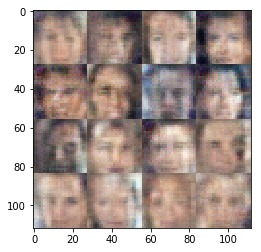

Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.9120
Epoch 1/1... Discriminator Loss: 0.0931... Generator Loss: 3.7237
Epoch 1/1... Discriminator Loss: 2.3679... Generator Loss: 2.0011
Epoch 1/1... Discriminator Loss: 0.0812... Generator Loss: 3.2235
Epoch 1/1... Discriminator Loss: 1.9474... Generator Loss: 3.3330
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 0.8815


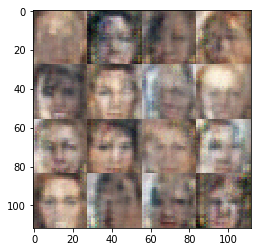

Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 4.9191
Epoch 1/1... Discriminator Loss: 0.0271... Generator Loss: 4.2295
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 3.9775
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 1.3707
Epoch 1/1... Discriminator Loss: 1.8993... Generator Loss: 0.2277


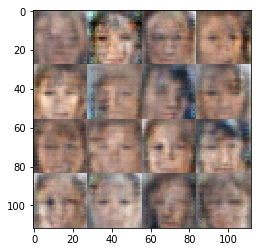

Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.6657... Generator Loss: 0.2782
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.7823
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.4732


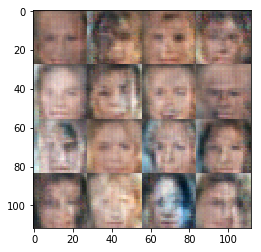

Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 0.2742... Generator Loss: 1.9565
Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 2.6888


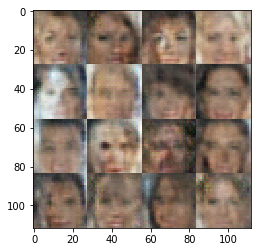

Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.1695
Epoch 1/1... Discriminator Loss: 2.5911... Generator Loss: 0.1178
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 0.7101


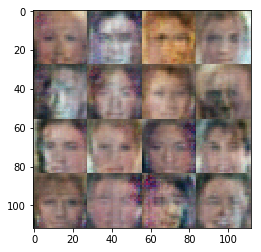

Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 0.3049... Generator Loss: 1.8304
Epoch 1/1... Discriminator Loss: 3.2749... Generator Loss: 4.7990
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 1.0612


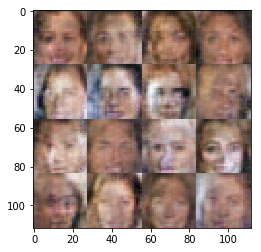

Epoch 1/1... Discriminator Loss: 0.1696... Generator Loss: 2.3548
Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 4.1770
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 2.7977
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.4856
Epoch 1/1... Discriminator Loss: 0.1307... Generator Loss: 2.7143


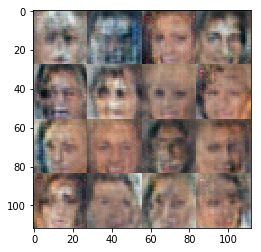

Epoch 1/1... Discriminator Loss: 0.1323... Generator Loss: 4.8526
Epoch 1/1... Discriminator Loss: 0.0399... Generator Loss: 4.0450
Epoch 1/1... Discriminator Loss: 0.4318... Generator Loss: 1.3509
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 2.3336


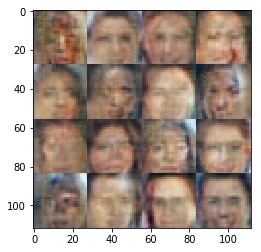

Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.6154
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.7831... Generator Loss: 0.7268


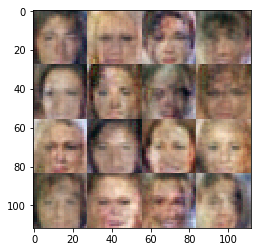

Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 1.4667
Epoch 1/1... Discriminator Loss: 1.7541... Generator Loss: 2.3892
Epoch 1/1... Discriminator Loss: 0.4814... Generator Loss: 1.5075
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.8322


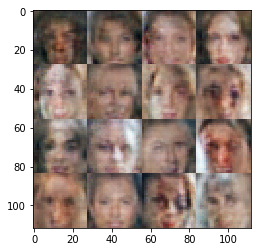

Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.9899
Epoch 1/1... Discriminator Loss: 0.3604... Generator Loss: 2.1243
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.9153
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 2.0432
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.5578


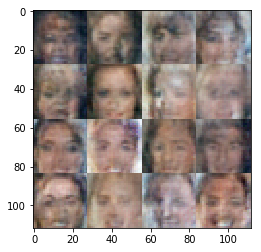

Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.6850
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 0.3813... Generator Loss: 1.6550
Epoch 1/1... Discriminator Loss: 0.6518... Generator Loss: 2.0627
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.4868


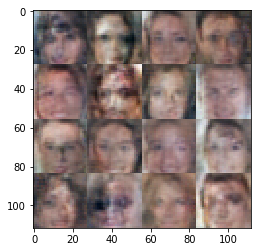

Epoch 1/1... Discriminator Loss: 0.1421... Generator Loss: 5.4467
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 2.9516
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 0.1981... Generator Loss: 2.5573


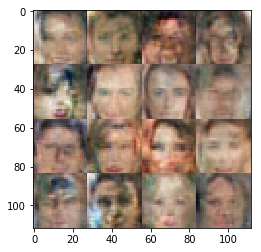

Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 0.4328... Generator Loss: 1.4886
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 0.1208... Generator Loss: 4.3258
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 4.0647


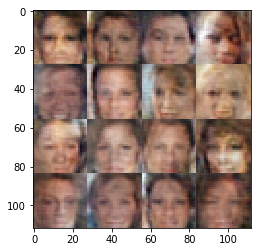

Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 1.2101
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.6116... Generator Loss: 2.6726
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.6327


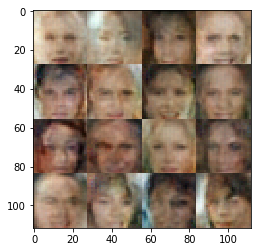

Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.7228
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 0.6604... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.5473


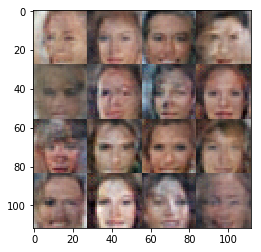

Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.2248
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 3.1065
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.7119


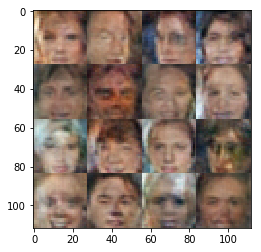

Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 2.2730... Generator Loss: 3.1741
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 2.2314
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.3472
Epoch 1/1... Discriminator Loss: 0.4767... Generator Loss: 2.4061
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.3080


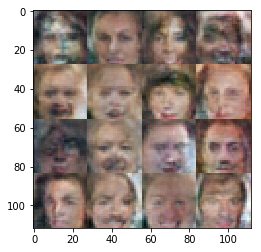

Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 1.4321
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.3323
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 1.5708
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 0.3009
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.4393


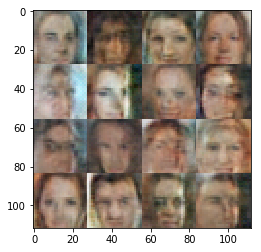

Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.0463... Generator Loss: 2.3112
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 3.4108
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 1.1105


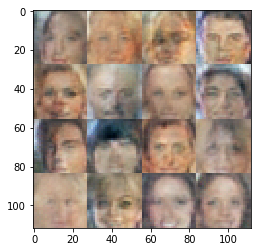

Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.3812
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 2.1124
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.2670
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.6154


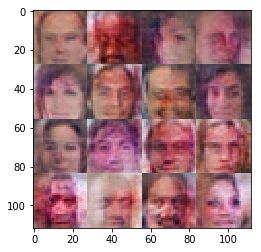

Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.6846... Generator Loss: 0.2948
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 2.2000
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 2.3415


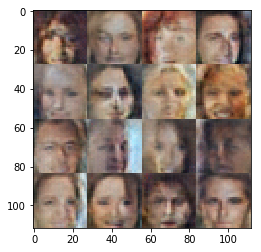

Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.3174
Epoch 1/1... Discriminator Loss: 2.1079... Generator Loss: 0.1699
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 0.2536... Generator Loss: 2.0806


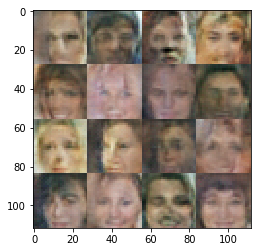

Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 1.9865
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 1.2509
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.1625


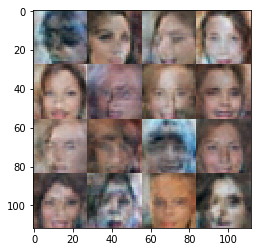

Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.8330
Epoch 1/1... Discriminator Loss: 2.0400... Generator Loss: 0.1905
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.6393
Epoch 1/1... Discriminator Loss: 1.7418... Generator Loss: 3.6027
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.1991
Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 2.6615


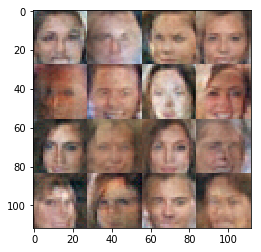

Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.3610
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 1.4401
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 2.6449
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.0464


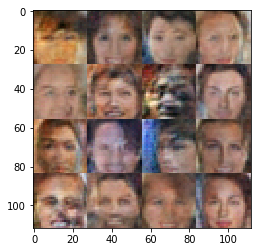

Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 1.5525
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 2.2559
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.3968
Epoch 1/1... Discriminator Loss: 0.3271... Generator Loss: 1.9826
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 0.8538... Generator Loss: 2.9646


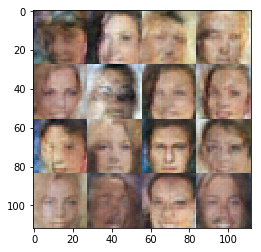

Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 1.4643
Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 0.5122... Generator Loss: 2.0548
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.3222
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.2761


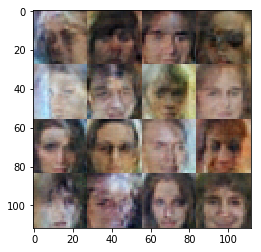

Epoch 1/1... Discriminator Loss: 0.2697... Generator Loss: 2.0887
Epoch 1/1... Discriminator Loss: 1.8641... Generator Loss: 0.2744
Epoch 1/1... Discriminator Loss: 0.4048... Generator Loss: 3.2151
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 2.0166
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.7054


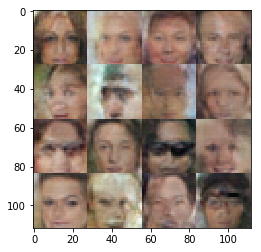

Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 1.1319
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 2.7048
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 2.4592
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 2.4409
Epoch 1/1... Discriminator Loss: 0.5115... Generator Loss: 1.7573


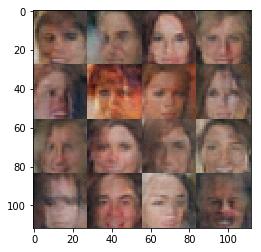

Epoch 1/1... Discriminator Loss: 0.5950... Generator Loss: 2.6737
Epoch 1/1... Discriminator Loss: 0.5702... Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.8816
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.4137
Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 3.2734
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.7466


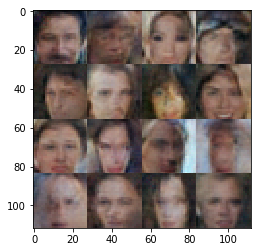

Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.5304


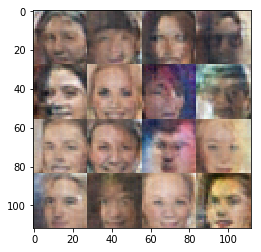

Epoch 1/1... Discriminator Loss: 1.6896... Generator Loss: 0.3029
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 1.6743
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.4065
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.3437


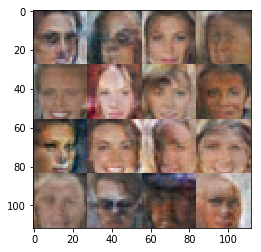

Epoch 1/1... Discriminator Loss: 0.6808... Generator Loss: 1.4698
Epoch 1/1... Discriminator Loss: 2.0350... Generator Loss: 0.1934
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 0.4636... Generator Loss: 3.1271
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.6717


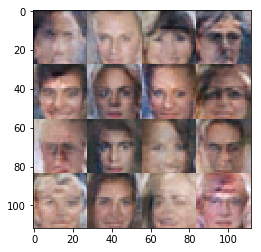

Epoch 1/1... Discriminator Loss: 0.5569... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 1.5525
Epoch 1/1... Discriminator Loss: 0.7350... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 0.3903... Generator Loss: 3.1493


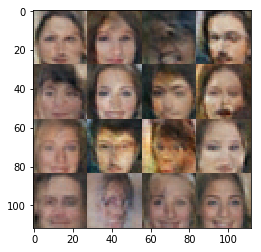

Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.7126
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 2.5442
Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 2.0581
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 3.0025
Epoch 1/1... Discriminator Loss: 1.8756... Generator Loss: 0.2317


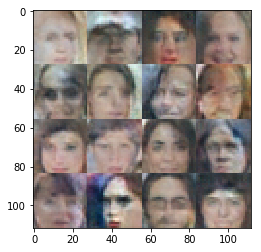

Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 2.9940
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 2.6784
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 0.7446... Generator Loss: 1.0263
Epoch 1/1... Discriminator Loss: 0.6207... Generator Loss: 1.8784
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 2.0213
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.3199


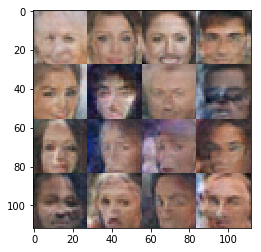

Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 0.4764... Generator Loss: 1.2371
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.9455


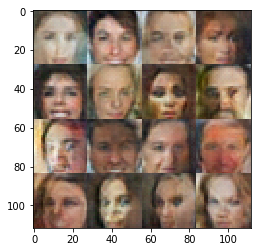

Epoch 1/1... Discriminator Loss: 1.9707... Generator Loss: 0.2234
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 1.3517
Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 1.5255
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 2.2093... Generator Loss: 0.1669


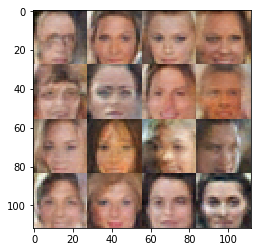

Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 2.2780
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.7001
Epoch 1/1... Discriminator Loss: 1.8046... Generator Loss: 0.2245
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 2.0785
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.7290


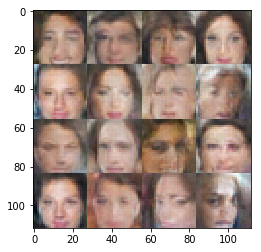

Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 2.2172
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.4523
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 1.1713


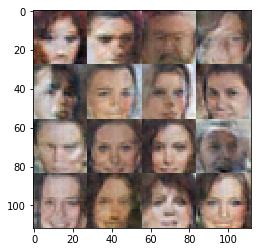

Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 1.4704
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 1.5514
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.3473
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 1.3692
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.3115


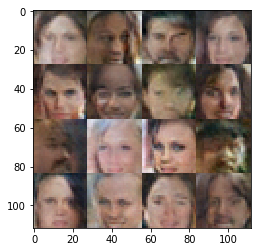

Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.4082
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.0208
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 1.4816
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 0.9730


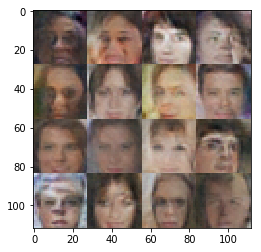

Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.4043
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.4797


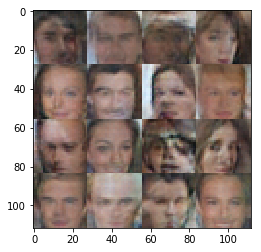

Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 1.1927
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 1.6349
Epoch 1/1... Discriminator Loss: 2.0068... Generator Loss: 0.2143
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.7149... Generator Loss: 0.2640
Epoch 1/1... Discriminator Loss: 1.8112... Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 0.8368


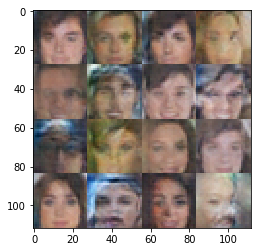

Epoch 1/1... Discriminator Loss: 1.8401... Generator Loss: 0.2449
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 1.6362
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.3211
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 0.7199... Generator Loss: 0.9922


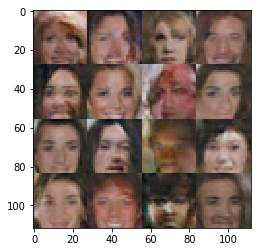

Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 1.4026
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 2.4537
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 1.8362
Epoch 1/1... Discriminator Loss: 2.3793... Generator Loss: 0.1477
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 2.0663
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.2363


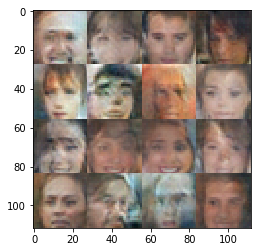

Epoch 1/1... Discriminator Loss: 0.3028... Generator Loss: 2.0576
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 1.3547
Epoch 1/1... Discriminator Loss: 2.4031... Generator Loss: 0.1561
Epoch 1/1... Discriminator Loss: 0.3195... Generator Loss: 2.0803
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.6531... Generator Loss: 1.0546


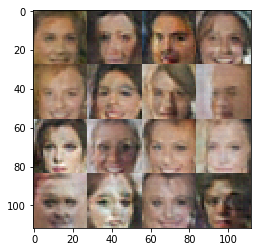

Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 0.6550... Generator Loss: 1.3344
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 0.7090


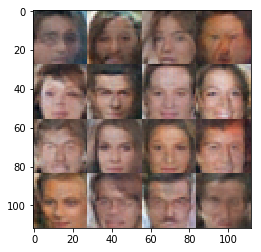

Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 0.3359... Generator Loss: 2.1546
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 1.5103


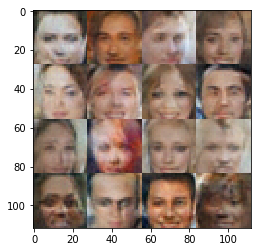

Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 1.6130
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.3598
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 0.4380... Generator Loss: 1.7193
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 2.8257


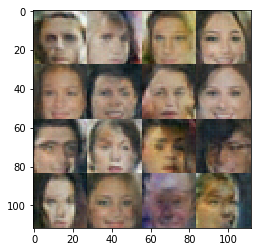

Epoch 1/1... Discriminator Loss: 2.0605... Generator Loss: 0.1921
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.4226
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.8409


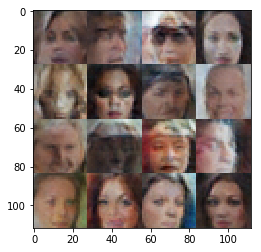

Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 2.3626
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 0.9885


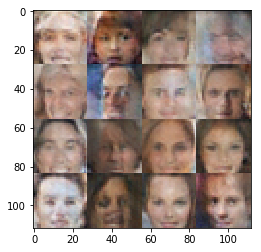

Last train discriminator Loss: 0.8369
Last train generator Loss: 0.9885


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.